In [28]:
%matplotlib inline
import numpy as np

import torch
import seaborn as sns
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [29]:

import pandas as pd
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(train_data.shape, test_data.shape)

(47439, 41) (31626, 40)


In [30]:
[i for i in train_data.columns if i not in test_data.columns]

['Sold Price']

In [31]:
train_data.columns

Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Region', 'Elementary School',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School', 'Middle School Score', 'Middle School Distance',
       'High School', 'High School Score', 'High School Distance', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Tax assessed value',
       'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')

In [32]:
test_data.columns

Index(['Id', 'Address', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling',
       'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip', 'State'],
      dtype='object')

In [33]:
all_features = pd.concat((train_data.iloc[:, 4:-1], test_data.iloc[:, 3:-1]))

all_features.shape



(79065, 36)

In [34]:
missing_values_count = all_features.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count.loc[missing_values_count>0]

Year built                      1942
Heating                        11513
Cooling                        15109
Parking                         1676
Lot                            22989
Bedrooms                        4598
Bathrooms                       5410
Full bathrooms                 12928
Total interior livable area     3878
Total spaces                    1667
Garage spaces                   1667
Region                             2
Elementary School               8493
Elementary School Score         8735
Elementary School Distance      8493
Middle School                  28277
Middle School Score            28279
Middle School Distance         28277
High School                     7174
High School Score               7784
High School Distance            7175
Flooring                       21927
Heating features               12548
Cooling features               16633
Appliances included            23349
Laundry features               19982
Parking features                6628
T

In [35]:
#计算一下数据集中缺失值占数据总数的......
total_cells = np.product(all_features.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing , '%')

13.693198985363662 %


In [36]:
all_features = all_features.fillna(method='bfill', axis=0).fillna(0)
# method='bfill',axis=0. 表示对于缺失位置按照bfill方法(使用下一个非缺失来填充)，如果最后几个值都是缺失的，则按照fillna(0)用0来填充

In [37]:
#验证一下是否NA都去除了
missing_values_count = all_features.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count.loc[missing_values_count>0]

Series([], dtype: int64)

In [38]:
all_features.columns

Index(['Type', 'Year built', 'Heating', 'Cooling', 'Parking', 'Lot',
       'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip'],
      dtype='object')

In [39]:
print(all_features['Listed On'].head())
print(all_features['Last Sold On'].head())

0    2019-10-24
1    2019-10-16
2    2019-08-25
3    2019-10-24
4    2019-06-07
Name: Listed On, dtype: object
0    2019-08-30
1    2019-08-30
2    2016-08-30
3    2016-08-30
4    2016-06-27
Name: Last Sold On, dtype: object


In [40]:
#将日期 从'object'类型转化为'datetime'类型
all_features['Listed On'] = pd.to_datetime(all_features['Listed On'], format="%Y-%m-%d")
all_features['Last Sold On'] = pd.to_datetime(all_features['Last Sold On'], format="%Y-%m-%d")

In [41]:
print(all_features['Listed On'].head())
print(all_features['Last Sold On'].head())

0   2019-10-24
1   2019-10-16
2   2019-08-25
3   2019-10-24
4   2019-06-07
Name: Listed On, dtype: datetime64[ns]
0   2019-08-30
1   2019-08-30
2   2016-08-30
3   2016-08-30
4   2016-06-27
Name: Last Sold On, dtype: datetime64[ns]


In [42]:
all_features.dtypes.unique()
# dtype('<M8[ns]') 表示的是“时间戳”(datetime)数据类型

array([dtype('O'), dtype('float64'), dtype('<M8[ns]'), dtype('int64')],
      dtype=object)

In [43]:
#进行标准化
num_features = all_features.dtypes[all_features.dtypes == 'float64'].index
all_features[num_features] = all_features[num_features].apply(
    lambda x:((x-x.mean())/x.std())
)
#  不同特征的数值范围可能差异很大。例如，房价可能在几十万到几百万之间，而其他特征（如房间数量、面积等）可能
#  在几到几十之间。标准化可以将所有特征缩放到相似的范围，使得模型在训练时不会偏向于数值较大的特征。

In [44]:
all_features.dtypes[all_features.dtypes == 'object']

Type                   object
Heating                object
Cooling                object
Parking                object
Bedrooms               object
Region                 object
Elementary School      object
Middle School          object
High School            object
Flooring               object
Heating features       object
Cooling features       object
Appliances included    object
Laundry features       object
Parking features       object
City                   object
dtype: object

In [45]:
obj_features = all_features.dtypes[all_features.dtypes == 'object'].index
# 为了提高独热编码时的质量，我们看一下这些object类型中是否存在数据不一致的情况：
print(all_features.shape)
onehot_num = 0
for column in obj_features:
    onehot_num += len(all_features[column].unique())
    print(f"{column}:{len(all_features[column].unique())}")
print(onehot_num)


(79065, 36)
Type:174
Heating:2659
Cooling:910
Parking:9912
Bedrooms:277
Region:1258
Elementary School:3567
Middle School:809
High School:921
Flooring:1739
Heating features:1762
Cooling features:595
Appliances included:11290
Laundry features:3030
Parking features:9694
City:1122
49719


从上面代码结果可以发现，有许多特征非重复数量较大，如果直接对obj数据进行one_hot特征提取的话，复杂度过高
因为水平有限，故只采取部分类数较少的obj特征数据作为训练数据


In [46]:
#main_obj_features = ['Type', 'Cooling', 'Bedrooms', 'Middle School', 'High School', 'Cooling features']

features = list(num_features)

features.append('Type')

# features.append("Cooling")
# features.append("Bedrooms")
# features.append("Middle School")
# features.append("High School")
# features.append("Cooling features")

all_features = all_features[features]
all_features.shape



(79065, 18)

In [47]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

#(79065, 192)

(79065, 192)

In [48]:

num_train = train_data.shape[0]
train_features = torch.tensor(all_features[:num_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[num_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1,1), dtype=torch.float32)
in_features = train_features.shape[1]


In [49]:
#数据分批
batch_size = 256
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(dataset,                   # 数据
                                          batch_size = batch_size,    # 每个batch大小
                                          shuffle = True,             # 是否打乱数据
                                          num_workers = 0,            # 工作线程
                                          pin_memory = True)
print(f"每一批{len(next(iter(train_loader))[0])}个，一共{len(train_loader)}批")


每一批256个，一共186批


In [50]:
class MyNet(nn.Module):
    def __init__(self, in_put, hidden1, hidden2, hidden3, out_put, droupt_rate=0):
        super().__init__()
        self.linear1 = nn.Linear(in_put, hidden1)
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.linear3 = nn.Linear(hidden2, hidden3)
        self.linear4 = nn.Linear(hidden3, out_put)
        self.dropout = nn.Dropout(droupt_rate)
    def forward(self, data):
        x  = self.linear1(data)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear4(x)
        return x

In [51]:
# 输入特征个数为训练集的列的个数
in_put = train_features.shape[1]
hidden1 , hidden2, hidden3, out_put = 256, 128, 16, 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyNet(in_put, hidden1, hidden2, hidden3, out_put).to(device)

loss = nn.MSELoss()
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)

In [52]:
print(model)

MyNet(
  (linear1): Linear(in_features=192, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


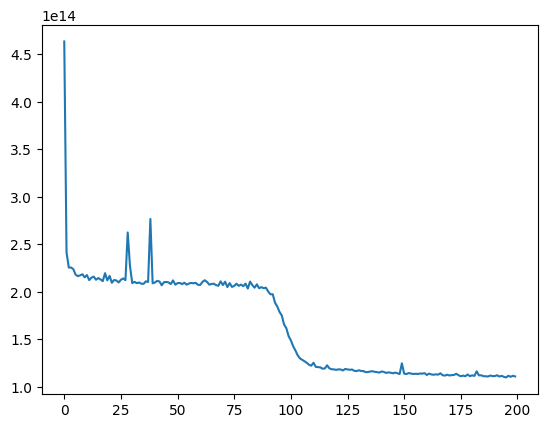

In [53]:
epochs = 200
def train(train_loader):
    train_ls = []
    for epoch in range(epochs):
        loss_sum = 0
        for train_batch, labels_batch in train_loader:
            train_batch, labels_batch = train_batch.to(device), labels_batch.to(device)
            #preds = torch.clamp(model(train_batch), 1, float('inf'))
            #l = torch.sqrt(loss(torch.log(preds), torch.log(labels_batch)))
            l = loss(model(train_batch),labels_batch)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_sum += l.item()
        train_ls.append(loss_sum)
    plt.plot(range(epochs), train_ls)
    plt.show()
train(train_loader)

In [54]:
def test(test_features):
    test_features = test_features.to(device)
    # 将计算图从当前张量中分离，防止在后续操作中计算梯度，并将tensor转换为numpy数组
    preds = model(test_features).detach().to("cpu").numpy()
    # squeeze()方法用于去除数组中维度为1的维度
    print(preds.shape, preds.squeeze().shape)
      
    #pandas.Series 创建新维度
    test_data['Sold Price'] = pd.Series(preds.squeeze())
    
    #axis选择拼接的维度
    return pd.concat([test_data['Id'], test_data['Sold Price']], axis = 1)
submission = test(test_features)
submission.to_csv('submission.csv', index=False)

(31626, 1) (31626,)
